<a href="https://colab.research.google.com/github/wh-hm/aws/blob/main/python_sisei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display




model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [ ]:
!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent


shape: (1, 1, 17, 3)
[[0.33078307 0.57207555 0.369262  ]
 [0.31447473 0.57787424 0.6351388 ]
 [0.31236157 0.552008   0.5708568 ]
 [0.3197211  0.55927014 0.28330055]
 [0.31868088 0.49974856 0.55858725]
 [0.41198176 0.54748225 0.4485066 ]
 [0.41022906 0.43935305 0.63575464]
 [0.5048667  0.65530074 0.4678775 ]
 [0.50849646 0.52826107 0.6649904 ]
 [0.42503965 0.640712   0.5084339 ]
 [0.4205613  0.6175595  0.55401313]
 [0.6047405  0.41460285 0.5882532 ]
 [0.6076926  0.32068336 0.7141807 ]
 [0.6492917  0.56412    0.5011436 ]
 [0.6847606  0.4275723  0.6753651 ]
 [0.8359229  0.51886916 0.3680051 ]
 [0.89923644 0.35467625 0.5767887 ]]


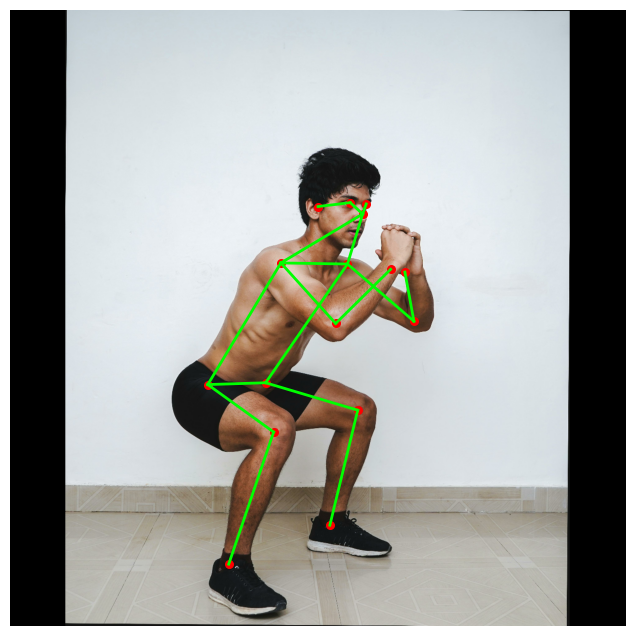

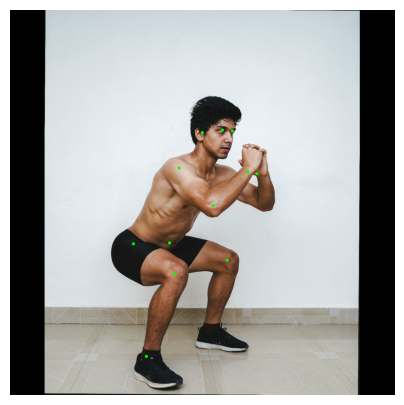

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display



# COCOのキーポイントのつながり（親 -> 子）
KEYPOINT_EDGES = {
    (0, 1): 'm',  # nose -> left_eye
    (0, 2): 'm',  # nose -> right_eye
    (1, 3): 'm',  # left_eye -> left_ear
    (2, 4): 'm',  # right_eye -> right_ear
    (0, 5): 'm',  # nose -> left_shoulder
    (0, 6): 'm',  # nose -> right_shoulder
    (5, 7): 'm',  # left_shoulder -> left_elbow
    (7, 9): 'm',  # left_elbow -> left_wrist
    (6, 8): 'm',  # right_shoulder -> right_elbow
    (8, 10): 'm', # right_elbow -> right_wrist
    (5, 6): 'm',  # left_shoulder -> right_shoulder
    (5, 11): 'm', # left_shoulder -> left_hip
    (6, 12): 'm', # right_shoulder -> right_hip
    (11, 12): 'm',# left_hip -> right_hip
    (11, 13): 'm',# left_hip -> left_knee
    (13, 15): 'm',# left_knee -> left_ankle
    (12, 14): 'm',# right_hip -> right_knee
    (14, 16): 'm' # right_knee -> right_ankle
}


model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)




  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

def draw_prediction_on_image(image, keypoints_with_scores, crop_region=None, close_figure=True, output_image_height=None):
      """Draws the keypoint predictions on the image."""
      height, width, channel = image.shape
      aspect_ratio = float(width) / height
      fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
      # Show image.
      ax.imshow(image)
      # Draw keypoints.

      for idx, keypoint in enumerate(keypoints_with_scores[0,0,:,:]):
        y, x, confidence = keypoint
        if confidence < 0.5:  # 信頼度が低い点は描かない
            continue
        # 画像サイズに合わせて座標変換
        x_coord = int(x * image.shape[1])
        y_coord = int(y * image.shape[0])
        cv2.circle(image, (x_coord, y_coord), 5, (0, 255, 0), -1)

      keypoints = keypoints_with_scores[0, 0, :, :].reshape(17, 3)
      for kp in keypoints:
          y, x, confidence = kp
          if confidence > 0.3:  # 信頼度が一定以上の点だけ描画
              ax.plot(x * width, y * height, 'ro', markersize=5)

      ax.axis('off')
      if close_figure:
          plt.close(fig)
      return image



def draw_keypoints_and_edges(image, keypoints, edges, confidence_threshold=0.3):
    plt.figure(figsize=(8,8))
    plt.imshow(image)

    h, w, _ = image.shape
    for i, kp in enumerate(keypoints[0,0,:,:]):
        y, x, c = kp
        if c > confidence_threshold:
            plt.scatter(x * w, y * h, c='red', s=30)

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints[0,0,p1,:]
        y2, x2, c2 = keypoints[0,0,p2,:]
        if (c1 > confidence_threshold) and (c2 > confidence_threshold):
            plt.plot([x1 * w, x2 * w], [y1 * h, y2 * h], color='lime', linewidth=2)

    plt.axis('off')
    plt.show()





# 入力画像を読み込む。
image_path = 'input_image.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)
print("shape:", keypoints_with_scores.shape)
print(keypoints_with_scores[0,0,:,:])


# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

# 呼び出し
draw_keypoints_and_edges(
    np.squeeze(display_image.numpy(), axis=0),
    keypoints_with_scores,
    KEYPOINT_EDGES
)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像読み込み ---
image_path = 'input_image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(image, (192,192))
input_image = input_image / 255.0
input_image = input_image.astype(np.float32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)

# --- COCOキーポイントの線 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    # キーポイント
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    # 線
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ストレートネック判定関数 ---
def check_straight_neck(keypoints_with_scores):
    keypoints = keypoints_with_scores[0,0,:,:2]  # (17,2)
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    shoulder_center = (left_shoulder + right_shoulder)/2
    nose = keypoints[0]
    neck_vector = nose - shoulder_center
    angle_rad = np.arctan2(neck_vector[1], neck_vector[0])
    angle_deg = np.degrees(angle_rad)
    # 判定の目安（水平=0度、30度以上は傾き大）
    if -10 < angle_deg < 30:
        status = "ストレートネック傾向あり"
    else:
        status = "首の傾きは正常範囲"
    return angle_deg, status

# --- 描画と判定 ---
image_with_keypoints = draw_keypoints_and_edges(
    image,
    keypoints_with_scores[0,0,:,:2],
    KEYPOINT_EDGES
)

angle, status = check_straight_neck(keypoints_with_scores)
print("首の傾き角度(°):", angle)
print("判定:", status)

# --- 画像表示 ---
plt.figure(figsize=(8,8))
plt.imshow(image_with_keypoints)
plt.axis('off')
plt.show()


InvalidArgumentError: cannot compute __inference_signature_wrapper_105778 as input #0(zero-based) was expected to be a int32 tensor but is a float tensor [Op:__inference_signature_wrapper_105778]

首の傾き角度(°): -95.80603
判定: 首の傾きは正常範囲


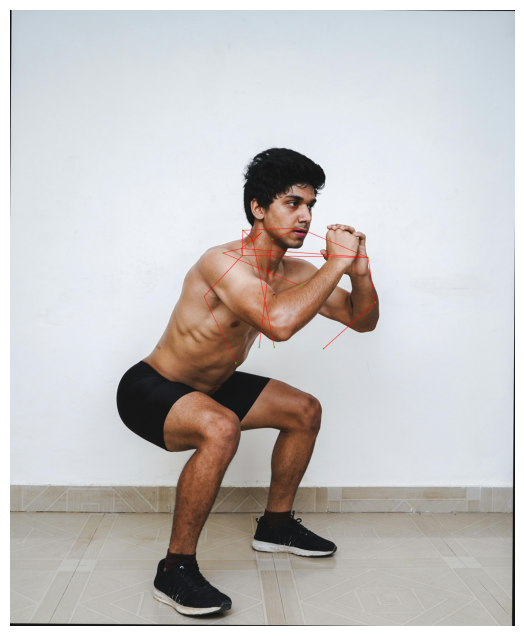

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像読み込み ---
image_path = 'input_image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image / 255.0
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)

# --- COCOキーポイントの線 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    # キーポイント
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    # 線
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ストレートネック判定関数 ---
def check_straight_neck(keypoints_with_scores):
    keypoints = keypoints_with_scores[0,0,:,:2]  # (17,2)
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    shoulder_center = (left_shoulder + right_shoulder)/2
    nose = keypoints[0]
    neck_vector = nose - shoulder_center
    angle_rad = np.arctan2(neck_vector[1], neck_vector[0])
    angle_deg = np.degrees(angle_rad)
    # 判定の目安（水平=0度、30度以上は傾き大）
    if -10 < angle_deg < 30:
        status = "ストレートネック傾向あり"
    else:
        status = "首の傾きは正常範囲"
    return angle_deg, status

# --- 推論結果のキーポイントを元画像サイズに変換 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2].copy()
keypoints_scaled[:,0] *= orig_height  # y
keypoints_scaled[:,1] *= orig_width   # x
keypoints_scaled = keypoints_scaled / np.array([orig_height, orig_width])  # [0,1] に戻す

# --- 描画と判定 ---
image_with_keypoints = draw_keypoints_and_edges(
    image,
    keypoints_scaled,
    KEYPOINT_EDGES
)

angle, status = check_straight_neck(keypoints_with_scores)
print("首の傾き角度(°):", angle)
print("判定:", status)

# --- 画像表示 ---
plt.figure(figsize=(8,8))
plt.imshow(image_with_keypoints)
plt.axis('off')
plt.show()


首の傾き角度(°): 155.54742
判定: 首の傾きは正常範囲


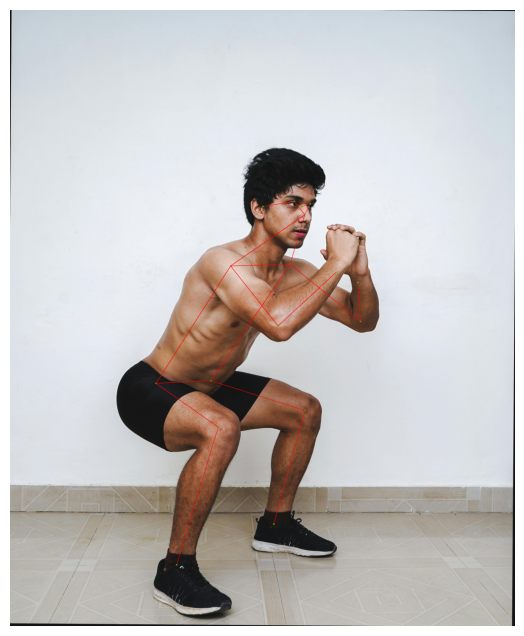

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像読み込み ---
image_path = 'input_image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 画像読み込み ---
image_path = 'input_image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = tf.convert_to_tensor(input_image, dtype=tf.int32)  # int32に変換
input_image = tf.expand_dims(input_image, axis=0)

#input_image = input_image / 255.0                 # float32で0-1に正規化
#input_image = input_image.astype(np.float32)      # int32は不要
#input_image = np.expand_dims(input_image, axis=0) # (1,192,192,3)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)


# --- COCOキーポイントの線 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    # キーポイント
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    # 線
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ストレートネック判定関数 ---
def check_straight_neck(keypoints_with_scores):
    keypoints = keypoints_with_scores[0,0,:,:2]  # (17,2)
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 耳の中点
    ear_center = (left_ear + right_ear)/2
    # 肩の中心
    shoulder_center = (left_shoulder + right_shoulder)/2

    # 耳-肩のベクトル
    neck_vector = ear_center - shoulder_center

    # 水平線との角度 (水平=0度)
    # np.arctan2(y差, x差) で反時計回りの角度(°)
    angle_rad = np.arctan2(neck_vector[1], neck_vector[0])
    angle_deg = np.degrees(angle_rad)

    # 判定（水平=0度、首が前に出てると正の角度）
    if -10 < angle_deg < 30:
        status = "ストレートネック傾向あり"
    else:
        status = "首の傾きは正常範囲"
    return angle_deg, status


# --- 推論結果のキーポイントを[0,1]にスケール ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2].copy()
# 元画像に合わせて描画する場合はスケーリング不要、[0,1]のままでOK

# --- 描画と判定 ---
image_with_keypoints = draw_keypoints_and_edges(
    image,
    keypoints_scaled,
    KEYPOINT_EDGES
)

angle, status = check_straight_neck(keypoints_with_scores)
print("首の傾き角度(°):", angle)
print("判定:", status)

# --- 画像表示 ---
plt.figure(figsize=(8,8))
plt.imshow(image_with_keypoints)
plt.axis('off')
plt.show()


首の傾き角度(°): 155.54742
判定: 首の傾きは正常範囲


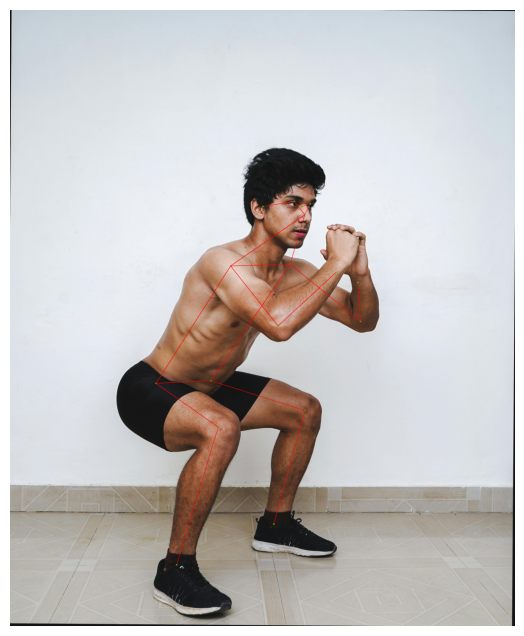

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像読み込み ---
image_path = 'input_image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image / 255.0
input_image = input_image.astype(np.float32)
input_image = np.expand_dims(input_image, axis=0)  # (1,192,192,3)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)

# --- COCOキーポイントの線 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ストレートネック判定関数 ---
def check_straight_neck(keypoints_with_scores):
    keypoints = keypoints_with_scores[0,0,:,:2]  # (17,2)
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 耳の中点
    ear_center = (left_ear + right_ear)/2
    # 肩の中心
    shoulder_center = (left_shoulder + right_shoulder)/2

    # 耳-肩のベクトル
    neck_vector = ear_center - shoulder_center

    # 水平線との角度
    angle_rad = np.arctan2(neck_vector[1], neck_vector[0])
    angle_deg = np.degrees(angle_rad)

    # 判定
    if -10 < angle_deg < 30:
        status = "ストレートネック傾向あり"
    else:
        status = "首の傾きは正常範囲"
    return angle_deg, status

# --- 推論結果のキーポイントを[0,1]にスケール ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画と判定 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
angle, status = check_straight_neck(keypoints_with_scores)
print("首の傾き角度(°):", angle)
print("判定:", status)

# --- 画像表示 ---
plt.figure(figsize=(8,8))
plt.imshow(image_with_keypoints)
plt.axis('off')
plt.show()



耳→肩の線と水平の角度: 118.61045966596521
首の傾き角度(°): 118.61045966596521
判定: 首の傾きは正常範囲


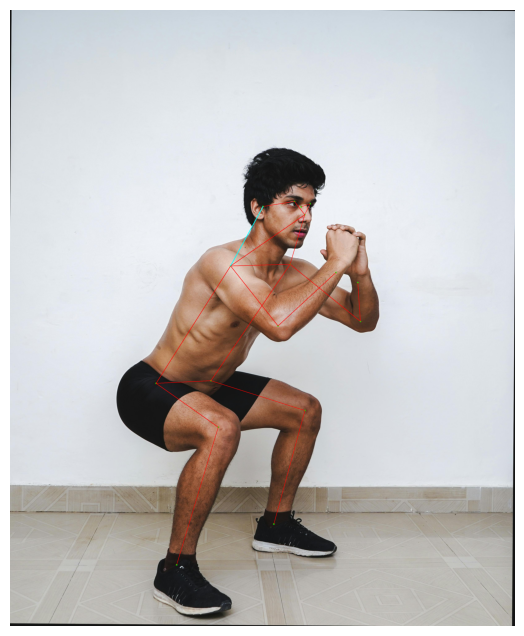

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像読み込み ---
image_path = 'input_image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)  # MoveNetはint32入力
input_image = np.expand_dims(input_image, axis=0)  # (1,192,192,3)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)

# --- COCOキーポイントの線 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- 耳と肩を結ぶ線を水色で描画 ---
def draw_ear_to_shoulder_line(image, keypoints):
    image = image.copy()
    height, width, _ = image.shape

    # 右側の耳と肩
    ear = keypoints[4]      # [y, x]
    shoulder = keypoints[6] # [y, x]

    # OpenCVは(x, y)なので順序逆
    x1, y1 = int(ear[1]*width), int(ear[0]*height)
    x2, y2 = int(shoulder[1]*width), int(shoulder[0]*height)

    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 3)  # 水色
    return image


# --- ストレートネック判定関数 ---
def check_straight_neck(keypoints_with_scores):
    keypoints = keypoints_with_scores[0,0,:,:2]  # (17,2)
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 耳の中点
    ear_center = (left_ear + right_ear)/2
    # 肩の中心
    shoulder_center = (left_shoulder + right_shoulder)/2

    # 耳-肩のベクトル
    neck_vector = ear_center - shoulder_center

    # 水平線との角度
    angle_rad = np.arctan2(neck_vector[1], neck_vector[0])
    angle_deg = np.degrees(angle_rad)

    # 判定
    if -10 < angle_deg < 30:
        status = "ストレートネック傾向あり"
    else:
        status = "首の傾きは正常範囲"
    return angle_deg, status

def draw_ear_to_shoulder_line_and_angle(image, keypoints):
    image = image.copy()
    height, width, _ = image.shape

    # 右側の耳と肩
    ear = keypoints[4]      # [y, x] 正規化座標
    shoulder = keypoints[6] # [y, x] 正規化座標

    # ピクセル座標に変換
    x1, y1 = int(ear[1]*width), int(ear[0]*height)
    x2, y2 = int(shoulder[1]*width), int(shoulder[0]*height)

    # 水色で線を描画
    cv2.line(image, (x1, y1), (x2, y2), (255, 255, 0), 3)

    # 水平線との角度を計算
    dx = x2 - x1
    dy = y2 - y1
    angle_rad = np.arctan2(dy, dx)  # 上方向が正なので arctan2
    angle_deg = np.degrees(angle_rad)

    return image, angle_deg

# --- 推論結果のキーポイントを[0,1]にスケール ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画と判定 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_ear_line = draw_ear_to_shoulder_line(image_with_keypoints, keypoints_scaled)
angle, status = check_straight_neck(keypoints_with_scores)
# 使い方
image_with_line, angle = draw_ear_to_shoulder_line_and_angle(image, keypoints_with_scores[0,0,:,:])
print("耳→肩の線と水平の角度:", angle)
print("首の傾き角度(°):", angle)
print("判定:", status)

# --- 画像表示 ---
plt.figure(figsize=(8,8))
plt.imshow(image_with_ear_line)
plt.axis('off')
plt.show()


耳→肩の線と水平の角度: 98.82037955202107
首の傾き角度(°): 98.82037955202107
判定: 首の傾きは正常範囲


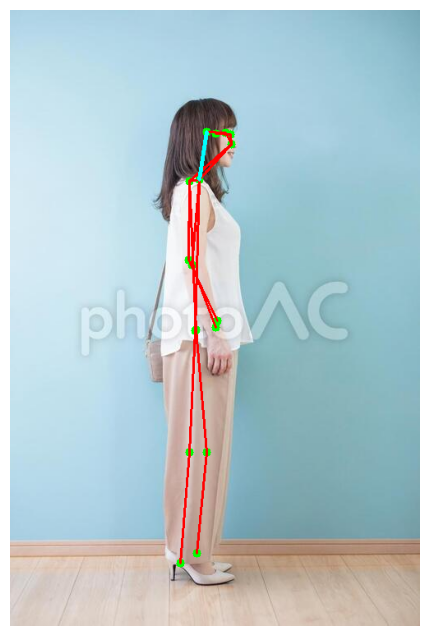

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt

url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'

# URLから画像を読み込む
resp = urllib.request.urlopen(url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- 画像読み込み ---
#image_path = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'
#image = cv2.imread(image_path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)  # MoveNetはint32入力
input_image = np.expand_dims(input_image, axis=0)  # (1,192,192,3)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)

# --- COCOキーポイントの線 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- 耳と肩を結ぶ線を水色で描画 ---
def draw_ear_to_shoulder_line(image, keypoints):
    image = image.copy()
    height, width, _ = image.shape

    # 右側の耳と肩
    ear = keypoints[4]      # [y, x]
    shoulder = keypoints[6] # [y, x]

    # OpenCVは(x, y)なので順序逆
    x1, y1 = int(ear[1]*width), int(ear[0]*height)
    x2, y2 = int(shoulder[1]*width), int(shoulder[0]*height)

    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 3)  # 水色
    return image


# --- ストレートネック判定関数 ---
def check_straight_neck(keypoints_with_scores):
    keypoints = keypoints_with_scores[0,0,:,:2]  # (17,2)
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 耳の中点
    ear_center = (left_ear + right_ear)/2
    # 肩の中心
    shoulder_center = (left_shoulder + right_shoulder)/2

    # 耳-肩のベクトル
    neck_vector = ear_center - shoulder_center

    # 水平線との角度
    angle_rad = np.arctan2(neck_vector[1], neck_vector[0])
    angle_deg = np.degrees(angle_rad)

    # 判定
    if -10 < angle_deg < 30:
        status = "ストレートネック傾向あり"
    else:
        status = "首の傾きは正常範囲"
    return angle_deg, status

def draw_ear_to_shoulder_line_and_angle(image, keypoints):
    image = image.copy()
    height, width, _ = image.shape

    # 右側の耳と肩
    ear = keypoints[4]      # [y, x] 正規化座標
    shoulder = keypoints[6] # [y, x] 正規化座標

    # ピクセル座標に変換
    x1, y1 = int(ear[1]*width), int(ear[0]*height)
    x2, y2 = int(shoulder[1]*width), int(shoulder[0]*height)

    # 水色で線を描画
    cv2.line(image, (x1, y1), (x2, y2), (255, 255, 0), 3)

    # 水平線との角度を計算
    dx = x2 - x1
    dy = y2 - y1
    angle_rad = np.arctan2(dy, dx)  # 上方向が正なので arctan2
    angle_deg = np.degrees(angle_rad)

    return image, angle_deg

# --- 推論結果のキーポイントを[0,1]にスケール ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画と判定 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_ear_line = draw_ear_to_shoulder_line(image_with_keypoints, keypoints_scaled)
angle, status = check_straight_neck(keypoints_with_scores)
# 使い方
image_with_line, angle = draw_ear_to_shoulder_line_and_angle(image, keypoints_with_scores[0,0,:,:])
print("耳→肩の線と水平の角度:", angle)
print("首の傾き角度(°):", angle)
print("判定:", status)

# --- 画像表示 ---
plt.figure(figsize=(8,8))
plt.imshow(image_with_ear_line)
plt.axis('off')
plt.show()


首の傾き角度(°): 98.82037955202107
判定: 首の傾きは正常範囲


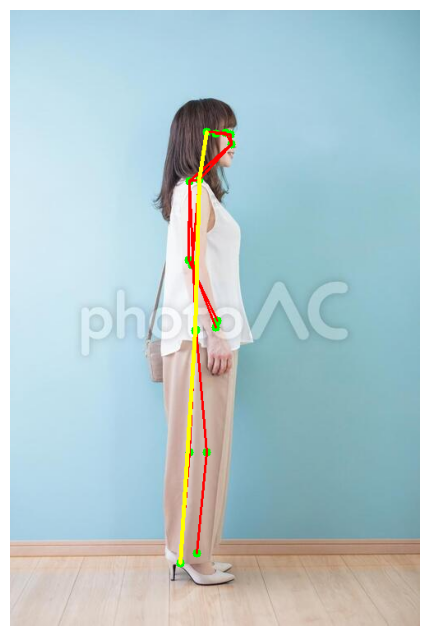

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像URL ---
url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'

# --- URLから画像を読み込む ---
resp = urllib.request.urlopen(url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)  # MoveNetはint32入力
input_image = np.expand_dims(input_image, axis=0)  # (1,192,192,3)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # (1,1,17,3)

# --- COCOキーポイントの線 (全身描画用) ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- 耳、肩、くるぶし、股関節を結ぶゴールデンライン描画関数 ---
def draw_golden_line(image, keypoints):
    image = image.copy()
    height, width, _ = image.shape

    # 右耳、右肩、右股関節、右くるぶし
    ear = keypoints[4]        # 右耳
    shoulder = keypoints[6]   # 右肩
    hip = keypoints[12]       # 右股関節
    ankle = keypoints[16]     # 右くるぶし

    # ピクセル座標に変換
    points = [(int(ear[1]*width), int(ear[0]*height)),
              (int(shoulder[1]*width), int(shoulder[0]*height)),
              (int(hip[1]*width), int(hip[0]*height)),
              (int(ankle[1]*width), int(ankle[0]*height))]

    # 線を描画
    for i in range(len(points)-1):
        cv2.line(image, points[i], points[i+1], (255, 255, 0), 3)  # 水色線
    return image


# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line = draw_golden_line(image_with_keypoints, keypoints_scaled)


# --- 結果表示 ---
print("首の傾き角度(°):", angle)
print("判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


ゴールデンライン判定: ゴールデンラインじゃないよ～


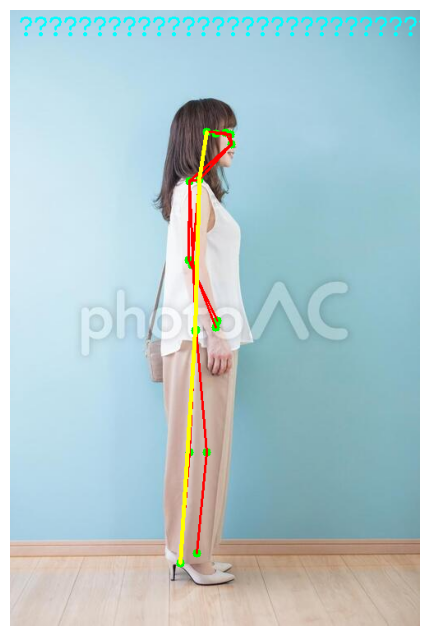

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像URL ---
url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'

# --- URLから画像を読み込む ---
resp = urllib.request.urlopen(url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()

# --- 全身キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ゴールデンライン描画と一直線判定 ---
def draw_golden_line(image, keypoints):
    image = image.copy()
    height, width, _ = image.shape

    # 右耳、右肩、右股関節、右くるぶし
    ear = keypoints[4]
    shoulder = keypoints[6]
    hip = keypoints[12]
    ankle = keypoints[16]

    points = np.array([
        [ear[1]*width, ear[0]*height],
        [shoulder[1]*width, shoulder[0]*height],
        [hip[1]*width, hip[0]*height],
        [ankle[1]*width, ankle[0]*height]
    ])

    for i in range(len(points)-1):
        cv2.line(image, tuple(points[i].astype(int)), tuple(points[i+1].astype(int)), (255, 255, 0), 3)

    # 直線性判定 (線形回帰で最大偏差)
    x = points[:,0]
    y = points[:,1]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_pred = m*x + c
    deviation = np.max(np.abs(y - y_pred))

    # 一定以下ならゴールデンライン
    threshold = 0
    #threshold = 10
    status = "ゴールデンライン" if deviation == threshold else "ゴールデンラインじゃないよ～"
    #status = "ゴールデンライン" if deviation <= threshold else "ゴールデンラインじゃないよ～"

    # 画像にテキスト描画
    if status:
        cv2.putText(image, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

    return image, status


# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, status = draw_golden_line(image_with_keypoints, keypoints_scaled)

# --- 結果表示 ---
print("ゴールデンライン判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


ゴールデンライン判定: Not Golden Line


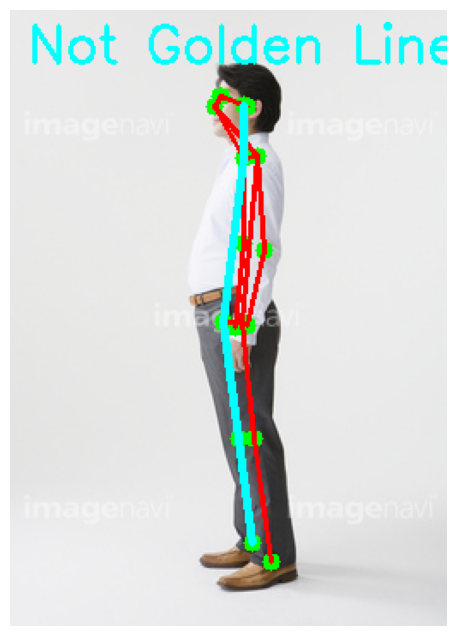

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 画像URL ---
#url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'
url = 'https://cpw.imagenavi.jp/preview/000/00046353_PW36.jpg'

# --- URLから画像を読み込む ---
resp = urllib.request.urlopen(url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()

# --- 全身キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ゴールデンライン描画と一直線判定 ---
def draw_golden_line(image, keypoints, threshold=5):
    image = image.copy()
    height, width, _ = image.shape

    # 右耳、右肩、右股関節、右くるぶし
    ear = keypoints[4]
    shoulder = keypoints[6]
    hip = keypoints[12]
    ankle = keypoints[16]

    points = np.array([
        [ear[1]*width, ear[0]*height],
        [shoulder[1]*width, shoulder[0]*height],
        [hip[1]*width, hip[0]*height],
        [ankle[1]*width, ankle[0]*height]
    ])

    # 水色で線を引く
    for i in range(len(points)-1):
        cv2.line(image, tuple(points[i].astype(int)), tuple(points[i+1].astype(int)), (0,255,255), 3)

    # 直線性判定 (線形回帰で最大偏差)
    x = points[:,0]
    y = points[:,1]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_pred = m*x + c
    deviation = np.max(np.abs(y - y_pred))

    # 判定
    status = "Golden Line" if deviation <= threshold else "Not Golden Line"

    # 画像にテキスト描画
    cv2.putText(image, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

    return image, status

# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, status = draw_golden_line(image_with_keypoints, keypoints_scaled)

# --- 結果表示 ---
print("ゴールデンライン判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


ファイル存在: True
ゴールデンライン判定: Not Golden Line


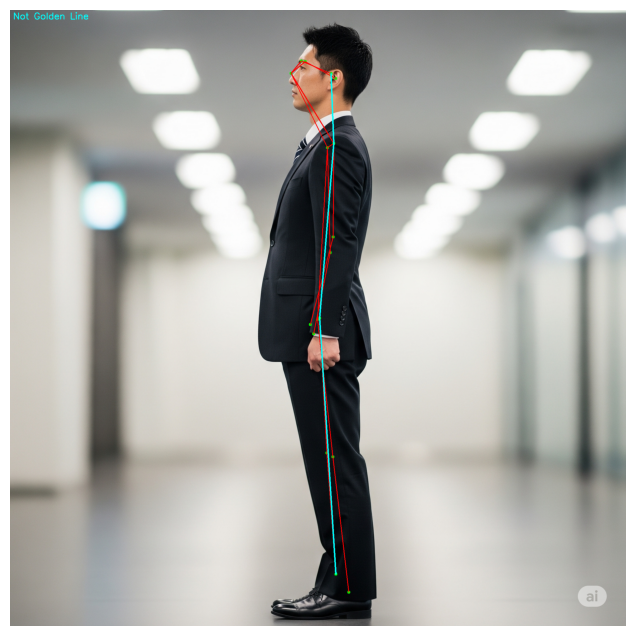

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 画像URL ---
#url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'
#url = 'https://cpw.imagenavi.jp/preview/000/00046353_PW36.jpg'
#url = 'https://oita-seikotsuin.com/wp-content/uploads/2021/03/5b1721b0b7144e004360fcb742a7bce4.jpg'
url = 'https://drive.google.com/file/d/15YhdF7pPGRjP0vzxk4qW_euMVDK7X52e/view?usp=drive_link'
# --- URLから画像を読み込む ---
#resp = urllib.request.urlopen(url)
#image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
#image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#orig_height, orig_width, _ = image.shape

image_path = "test.png"
print("ファイル存在:", os.path.exists(image_path))

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()

# --- 全身キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

# --- ゴールデンライン描画と一直線判定（向き自動判定版） ---
def draw_golden_line_auto(image, keypoints, threshold=5):
    image = image.copy()
    height, width, _ = image.shape

    # 肩と耳で向きを判定（x座標の差で左右）
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 人物が右向きか左向きか
    if right_shoulder[1] > left_shoulder[1]:  # x座標が大きい方が右
        facing_right = True
    else:
        facing_right = False

    # 向きに応じて使用する耳・肩・股関節・くるぶしを選択
    if facing_right:
        ear = right_ear
        shoulder = right_shoulder
        hip = keypoints[12]   # 右股関節
        ankle = keypoints[16] # 右足首
    else:
        ear = left_ear
        shoulder = left_shoulder
        hip = keypoints[11]   # 左股関節
        ankle = keypoints[15] # 左足首

    points = np.array([
        [ear[1]*width, ear[0]*height],
        [shoulder[1]*width, shoulder[0]*height],
        [hip[1]*width, hip[0]*height],
        [ankle[1]*width, ankle[0]*height]
    ])

    # 水色で線を引く
    for i in range(len(points)-1):
        cv2.line(image, tuple(points[i].astype(int)), tuple(points[i+1].astype(int)), (0,255,255), 3)

    # 直線性判定 (線形回帰で最大偏差)
    x = points[:,0]
    y = points[:,1]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_pred = m*x + c
    deviation = np.max(np.abs(y - y_pred))

    # 判定
    status = "Golden Line" if deviation <= threshold else "Not Golden Line"

    # 画像にテキスト描画
    cv2.putText(image, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

    return image, status

# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, status = draw_golden_line_auto(image_with_keypoints, keypoints_scaled)

print("ゴールデンライン判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


In [ ]:
!curl -o people.jpeg C:\python\image\people.png --silent

ゴールデンライン判定: Not Golden Line


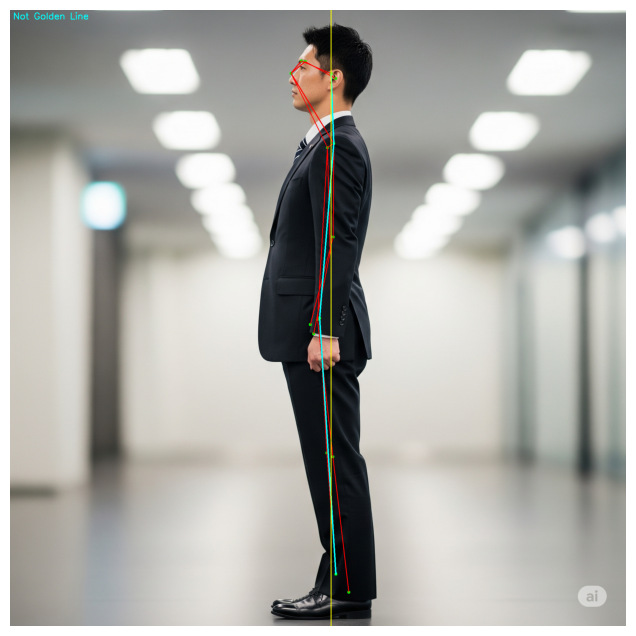

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 画像URL ---
#url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'
#url = 'https://cpw.imagenavi.jp/preview/000/00046353_PW36.jpg'
#url = 'https://oita-seikotsuin.com/wp-content/uploads/2021/03/5b1721b0b7144e004360fcb742a7bce4.jpg'
url = 'https://drive.google.com/file/d/15YhdF7pPGRjP0vzxk4qW_euMVDK7X52e/view?usp=drive_link'
# --- URLから画像を読み込む ---
#resp = urllib.request.urlopen(url)
#image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
#image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#orig_height, orig_width, _ = image.shape

image_path = "test.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()

# --- 全身キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

def draw_golden_line_auto(image, keypoints, threshold=5):
    image = image.copy()
    height, width, _ = image.shape

    # 肩と耳で向きを判定（x座標の差で左右）
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 人物が右向きか左向きか
    facing_right = right_shoulder[1] > left_shoulder[1]

    # 向きに応じて使用する耳・肩・股関節・くるぶしを選択
    if facing_right:
        ear = right_ear
        shoulder = right_shoulder
        hip = keypoints[12]   # 右股関節
        ankle = keypoints[16] # 右足首
    else:
        ear = left_ear
        shoulder = left_shoulder
        hip = keypoints[11]   # 左股関節
        ankle = keypoints[15] # 左足首

    # 実際の点群
    points = np.array([
        [ear[1]*width, ear[0]*height],
        [shoulder[1]*width, shoulder[0]*height],
        [hip[1]*width, hip[0]*height],
        [ankle[1]*width, ankle[0]*height]
    ])

    # 実際のゴールデンライン（耳～くるぶし）を水色で描く
    for i in range(len(points)-1):
        cv2.line(image, tuple(points[i].astype(int)), tuple(points[i+1].astype(int)), (0,255,255), 3)

    # ==== 理想の基準線（黄色で描く）====
    ear_x = int(points[0][0])
    cv2.line(image, (ear_x, 0), (ear_x, height), (255,255,0), 2)

    # 直線性判定 (線形回帰で最大偏差)
    x = points[:,0]
    y = points[:,1]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_pred = m*x + c
    deviation = np.max(np.abs(y - y_pred))

    # 判定
    status = "Golden Line" if deviation <= threshold else "Not Golden Line"

    # 画像にテキスト描画
    cv2.putText(image, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

    return image, status


# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, status = draw_golden_line_auto(image_with_keypoints, keypoints_scaled)

print("ゴールデンライン判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


ゴールデンライン判定: Golden Line Score: 0.0% (deviation=914.2px)


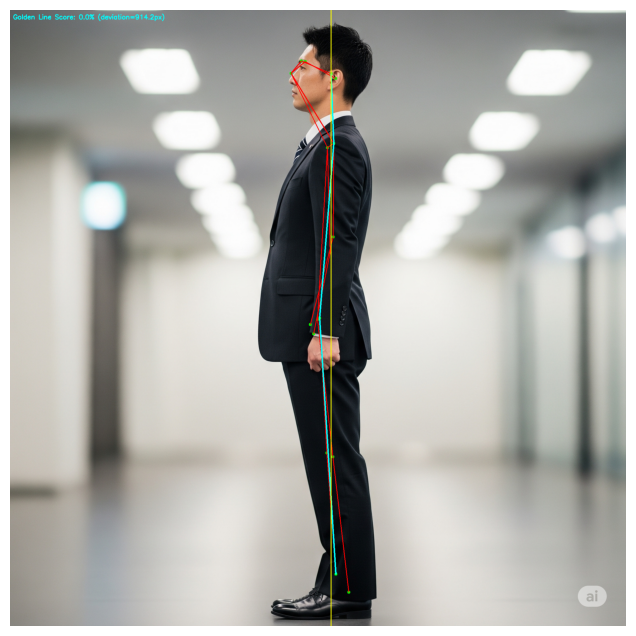

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 画像URL ---
#url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'
#url = 'https://cpw.imagenavi.jp/preview/000/00046353_PW36.jpg'
#url = 'https://oita-seikotsuin.com/wp-content/uploads/2021/03/5b1721b0b7144e004360fcb742a7bce4.jpg'
url = 'https://drive.google.com/file/d/15YhdF7pPGRjP0vzxk4qW_euMVDK7X52e/view?usp=drive_link'
# --- URLから画像を読み込む ---
#resp = urllib.request.urlopen(url)
#image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
#image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#orig_height, orig_width, _ = image.shape

image_path = "test.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()

# --- 全身キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

def draw_golden_line_auto(image, keypoints, threshold=5):
    image = image.copy()
    height, width, _ = image.shape

    # 肩と耳で向きを判定（x座標の差で左右）
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_ear = keypoints[3]
    right_ear = keypoints[4]

    # 人物が右向きか左向きか
    facing_right = right_shoulder[1] > left_shoulder[1]

    # 向きに応じて使用する耳・肩・股関節・くるぶしを選択
    if facing_right:
        ear = right_ear
        shoulder = right_shoulder
        hip = keypoints[12]   # 右股関節
        ankle = keypoints[16] # 右足首
    else:
        ear = left_ear
        shoulder = left_shoulder
        hip = keypoints[11]   # 左股関節
        ankle = keypoints[15] # 左足首

    # 実際の点群
    points = np.array([
        [ear[1]*width, ear[0]*height],
        [shoulder[1]*width, shoulder[0]*height],
        [hip[1]*width, hip[0]*height],
        [ankle[1]*width, ankle[0]*height]
    ])

    # 理想の基準線（黄色）
    for i in range(len(points)-1):
        cv2.line(image, tuple(points[i].astype(int)), tuple(points[i+1].astype(int)), (0,255,255), 3)

    # 実際のゴールデンライン（水色）
    ear_x = int(points[0][0])
    cv2.line(image, (ear_x, 0), (ear_x, height), (255,255,0), 2)

    # 直線性判定 (線形回帰で最大偏差)
    x = points[:,0]
    y = points[:,1]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_pred = m*x + c
    deviation = np.max(np.abs(y - y_pred))

    # 耳～足までの長さを基準にする
    line_length = np.linalg.norm(points[0] - points[-1])

    # 許容値を線の長さの 10% とする
    max_allowed = line_length * 0.1
    score = max(0, 100 - (deviation / max_allowed * 100))

    status = f"Golden Line Score: {score:.1f}% (deviation={deviation:.1f}px)"


    # 画像にテキスト描画
    cv2.putText(image, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    return image, status


# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, status = draw_golden_line_auto(image_with_keypoints, keypoints_scaled)

print("ゴールデンライン判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 画像URL ---
#url = 'https://thumb.photo-ac.com/65/65a14e470a3dbb62b8760f88e44d160c_w.jpeg'
#url = 'https://cpw.imagenavi.jp/preview/000/00046353_PW36.jpg'
#url = 'https://oita-seikotsuin.com/wp-content/uploads/2021/03/5b1721b0b7144e004360fcb742a7bce4.jpg'
url = 'https://drive.google.com/file/d/15YhdF7pPGRjP0vzxk4qW_euMVDK7X52e/view?usp=drive_link'
# --- URLから画像を読み込む ---
#resp = urllib.request.urlopen(url)
#image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
#image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#orig_height, orig_width, _ = image.shape

image_path = "test.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = input_image.astype(np.int32)
input_image = np.expand_dims(input_image, axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()

# --- 全身キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

# --- キーポイント描画関数 ---
def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

def draw_golden_line_auto(image, keypoints):
    height, width, _ = image.shape
    ear_x = int(keypoints[0][0])  # 耳を基準にする例

    # ゴールデンライン（基準線）
    cv2.line(image, (ear_x, 0), (ear_x, height), (0, 255, 255), 2)

    # 評価する部位（肩・腰・膝・くるぶし）
    target_indices = [5, 11, 13, 15]
    distances = []
    for idx in target_indices:
        if keypoints[idx][2] > 0.5:  # 信頼度が高いときだけ
            dx = abs(keypoints[idx][0] - ear_x)
            distances.append(dx)
            cv2.putText(image, f"{dx:.1f}px",
                        (int(keypoints[idx][0])+5, int(keypoints[idx][1])),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    # スコア計算（基準線からのズレの平均）
    if distances:
        avg_dist = sum(distances) / len(distances)
        max_width = width / 10  # 許容幅（画面幅の10%）
        score = max(0, 100 * (1 - avg_dist / max_width))
    else:
        score = 0

    cv2.putText(image, f"Score: {score:.1f}%", (20,40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    return image, score   # ★ 画像とスコアを返す



# --- 推論結果のスケール調整 ---
keypoints_scaled = keypoints_with_scores[0,0,:,:2]

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, status = draw_golden_line_auto(image_with_keypoints, keypoints_scaled)

print("ゴールデンライン判定:", status)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2

ゴールデンライン判定スコア: 0


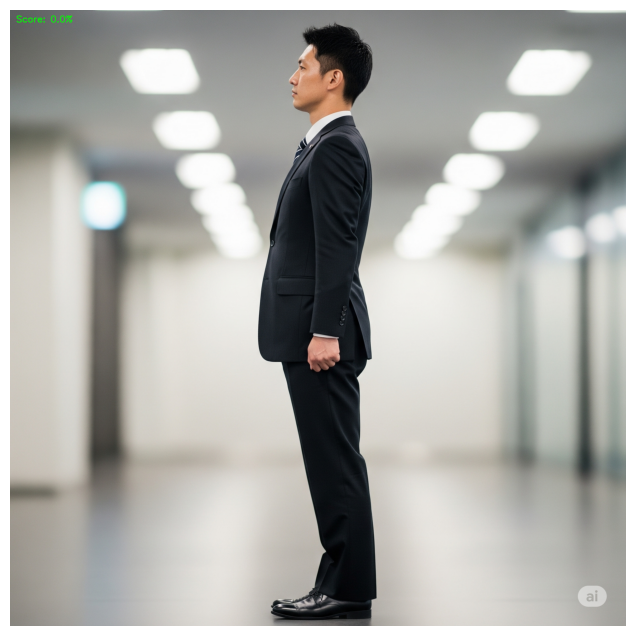

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 画像読み込み ---
image_path = "test.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_height, orig_width, _ = image.shape

# --- 推論用にリサイズ(192x192) ---
input_image = cv2.resize(image, (192,192))
input_image = np.expand_dims(input_image.astype(np.int32), axis=0)

# --- MoveNetモデル読み込み ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# --- 推論 ---
input_tensor = tf.convert_to_tensor(input_image)
outputs = movenet(input_tensor)
keypoints_with_scores = outputs['output_0'].numpy()  # shape=(1,1,17,3)

# --- キーポイント描画用 ---
KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x, score = keypoints[i]
        if score > 0.3:
            cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for i,j in edges:
            y1, x1, s1 = keypoints[i]
            y2, x2, s2 = keypoints[j]
            if s1>0.3 and s2>0.3:
                cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

def draw_golden_line_auto(image, keypoints):
    height, width, _ = image.shape
    ear_x = int(keypoints[0][1]*width)  # 耳のx座標を基準

    # ゴールデンライン
    cv2.line(image, (ear_x,0), (ear_x,height), (0,255,255), 2)

    # 評価部位：肩・腰・膝・くるぶし
    target_indices = [5,11,13,15]
    distances = []
    for idx in target_indices:
        y, x, score = keypoints[idx]
        x_pix = int(x*width)
        y_pix = int(y*height)
        if score > 0.5:
            dx = abs(x_pix - ear_x)
            distances.append(dx)
            cv2.putText(image, f"{dx}px", (x_pix+5,y_pix), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    # スコア計算（0～100）
    if distances:
        avg_dist = sum(distances)/len(distances)
        max_width = width/10
        score = max(0, 100*(1 - avg_dist/max_width))
    else:
        score = 0

    cv2.putText(image, f"Score: {score:.1f}%", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    return image, score

# --- 推論結果をリサイズ前の画像スケールに戻す ---
keypoints_scaled = keypoints_with_scores[0,0,:,:].copy()
keypoints_scaled[:,0] *= orig_height
keypoints_scaled[:,1] *= orig_width

# --- 描画 ---
image_with_keypoints = draw_keypoints_and_edges(image, keypoints_scaled, KEYPOINT_EDGES)
image_with_golden_line, score = draw_golden_line_auto(image_with_keypoints, keypoints_scaled)

print("ゴールデンライン判定スコア:", score)

plt.figure(figsize=(8,8))
plt.imshow(image_with_golden_line)
plt.axis('off')
plt.show()


SyntaxError: invalid syntax (ipython-input-2802553449.py, line 1)

In [14]:
from flask import Flask, render_template, request, jsonify
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import base64

app = Flask(__name__)

# --- MoveNetモデルロード ---
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

KEYPOINT_EDGES = [
    (0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),
    (5, 7),(7, 9),(6, 8),(8, 10),(5, 6),
    (5, 11),(6, 12),(11, 12),(11, 13),(13, 15),
    (12, 14),(14, 16)
]

def preprocess_image(image):
    image = cv2.resize(image, (192,192))
    image = image.astype(np.int32)
    return np.expand_dims(image, axis=0)

def draw_keypoints_and_edges(image, keypoints, edges=None):
    image = image.copy()
    height, width, _ = image.shape
    for i in range(keypoints.shape[0]):
        y, x = keypoints[i]
        cv2.circle(image, (int(x*width), int(y*height)), 5, (0,255,0), -1)
    if edges:
        for (i,j) in edges:
            y1, x1 = keypoints[i]
            y2, x2 = keypoints[j]
            cv2.line(image, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (255,0,0), 2)
    return image

def draw_golden_line_auto(image, keypoints):
    height, width, _ = image.shape
    ear_x = int(keypoints[0][0]*width)
    cv2.line(image, (ear_x, 0), (ear_x, height), (0, 255, 255), 2)

    target_indices = [5, 11, 13, 15]
    distances = []
    for idx in target_indices:
        dx = abs(keypoints[idx][0]*width - ear_x)
        distances.append(dx)
        cv2.putText(image, f"{dx:.1f}px",
                    (int(keypoints[idx][0]*width)+5, int(keypoints[idx][1]*height)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    score = max(0, 100 * (1 - np.mean(distances)/(width/10)))
    cv2.putText(image, f"Score: {score:.1f}%", (20,40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    return image, score

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/analyze", methods=["POST"])
def analyze():
    data = request.json
    img_data = data["image"].split(",")[1]
    img_bytes = base64.b64decode(img_data)
    nparr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_tensor = preprocess_image(img)
    outputs = movenet(tf.convert_to_tensor(input_tensor))
    keypoints_with_scores = outputs['output_0'].numpy()[0,0,:,:]

    image_with_kp = draw_keypoints_and_edges(img, keypoints_with_scores[:,:2], KEYPOINT_EDGES)
    result_img, score = draw_golden_line_auto(image_with_kp, keypoints_with_scores)

    _, buffer = cv2.imencode(".png", cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
    img_str = "data:image/png;base64," + base64.b64encode(buffer).decode()
    return jsonify({"result": img_str, "score": score})

if __name__ == "__main__":
    app.run(debug=True)


KeyboardInterrupt: 

In [ ]:
!python sisei/app.py

2025-08-25 08:14:01.924109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756109641.995705   10332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756109642.029366   10332 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756109642.073007   10332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756109642.073069   10332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756109642.073080   10332 computation_placer.cc:177] computation placer alr

In [16]:
!pip install flask-ngrok